In [30]:
import numpy as np
import numpy.random

import psycopg2
import cv2
import csv
import PIL
import os
import random
from PIL import Image
from PIL import ImageDraw
import pickle
from sklearn.utils import shuffle
import matplotlib
import matplotlib.pyplot as plt

# for generating heat map from frequency of points
import sphviewer as sph


In [31]:
# def plot_figures(figures, nrows = 1, ncols=1):
#     """Plot a dictionary of figures.

#     Parameters
#     ----------
#     figures : <title, figure> dictionary
#     ncols : number of columns of subplots wanted in the display
#     nrows : number of rows of subplots wanted in the figure
#     """

#     fig, axeslist = plt.subplots(ncols=ncols, nrows=nrows)
#     for ind,title in zip(range(len(figures)), figures):
#         axeslist.ravel()[ind].imshow(figures[title], cmap=plt.jet())
#         axeslist.ravel()[ind].set_title(title)
#         axeslist.ravel()[ind].set_axis_off()
#     plt.tight_layout() # optional

In [32]:
def heatmap_plot(x, y, nb=32, xsize=224, ysize=224):   
    xmin = np.min(x)
    xmax = np.max(x)
    ymin = np.min(y)
    ymax = np.max(y)

    x0 = (xmin+xmax)/2.
    y0 = (ymin+ymax)/2.

    pos = np.zeros([3, len(x)])
    pos[0,:] = x
    pos[1,:] = y
    w = np.ones(len(x))

    P = sph.Particles(pos, w, nb=nb)
    S = sph.Scene(P)
    S.update_camera(r='infinity', x=x0, y=y0, z=0, 
                    xsize=xsize, ysize=ysize)
    R = sph.Render(S)
    R.set_logscale()
    img = R.get_image()
    extent = R.get_extent()
    for i, j in zip(xrange(4), [x0,x0,y0,y0]):
        extent[i] += j
    return img, extent



In [26]:
# count no. of survey, right or wrong
cur.execute("ROLLBACK")
query = '''select distinct(category_a) from gare_st_lazare.survey group by category_a'''
cur.execute(query)
results2 = cur.fetchall()
conn.commit()

stats = []
total_cnt = 0

for i in results2:
    
    query = '''select count(*) from gare_st_lazare.survey where category_a = '%s' and decision = 'a' ''' % (i[0])
    cur.execute(query)
    a_cnt = cur.fetchone()[0]
    conn.commit()
    
    query = '''select count(*) from gare_st_lazare.survey where category_a = '%s' and decision = 'b' ''' % (i[0])
    cur.execute(query)
    b_cnt = cur.fetchone()[0]
    conn.commit()
    
    query = '''select count(*) from gare_st_lazare.survey where category_a = '%s' and decision = 'c' ''' % (i[0])
    cur.execute(query)
    c_cnt = cur.fetchone()[0]
    conn.commit()
    
    stats.append([i[0], a_cnt + b_cnt + c_cnt, a_cnt, b_cnt, c_cnt])
    total_cnt += a_cnt + b_cnt + c_cnt

query = '''truncate table gare_st_lazare.survey_stats; '''
cur.execute(query)
conn.commit()
    
for a in stats:
    query = '''insert into gare_st_lazare.survey_stats values('%s', %s, %s, %s, %s) ''' % (a[0], a[1], 
                                                                                      a[2], a[3], a[4])
    cur.execute(query)
    conn.commit()
#     print(i[0], a_cnt, b_cnt, c_cnt)
# print(stats)

In [33]:
# stats of cv results
cur.execute("ROLLBACK")
query = '''select category from gare_st_lazare.cv_results_225 group by category'''
cur.execute(query)
results2 = cur.fetchall()
conn.commit()

stats = []
total_cnt = 0

for i in results2:
    
    query = '''select avg(prob0) from gare_st_lazare.cv_results_225 where category = '%s' group by category''' % (i[0])
    cur.execute(query)
    confidence = cur.fetchone()[0]
    conn.commit()
    
    query = '''select count(*) from gare_st_lazare.cv_results_225 where category = '%s' and result = false ''' % (i[0])
    cur.execute(query)
    wrong_cnt = cur.fetchone()[0]
    conn.commit()
    
    query = '''select count(*) from gare_st_lazare.cv_results_225 where category = '%s' and result = true ''' % (i[0])
    cur.execute(query)
    right_cnt = cur.fetchone()[0]
    conn.commit()
    
    total_cnt = wrong_cnt + right_cnt
    accuracy  = right_cnt * 1.0 / total_cnt
    
    stats.append([i[0], confidence, total_cnt, right_cnt, wrong_cnt, accuracy])
    total_cnt += a_cnt + b_cnt + c_cnt

query = '''truncate table gare_st_lazare.cv_stats; '''
cur.execute(query)
conn.commit()
    
for a in stats:
    query = '''insert into gare_st_lazare.cv_stats values('%s', %s, %s, %s, %s, %s) ''' % (a[0], a[1], 
                                                                                      a[2], a[3], a[4], a[5])
    cur.execute(query)
    conn.commit()
#     print(i[0], a_cnt, b_cnt, c_cnt)
# print(stats)

In [34]:
limit = 500
h, w = (224, 224)
circle_r = 5

cv_table = 'cv_results_225'

conn_string = "host='localhost' dbname='indoor_position' user='postgres' password='tiancai' port='5432'"
conn = psycopg2.connect(conn_string)
cur = conn.cursor()

query = '''select img_id_a_0, count(img_id_a_0) from gare_st_lazare.survey 
        where decision = 'a' group by img_id_a_0 order by count(img_id_a_0) desc '''
cur.execute(query)
results1 = cur.fetchall()
conn.commit()


image   = []
heatmap = []
x_all   = []
y_all   = []
points  = []

for idx, item in enumerate(results1):
    
    if idx == limit:
        break

#     query = '''select * from gare_st_lazare.survey 
#         where decision = 'a' and img_id_a_0 = '%s' ''' % (item[0])
    
    query = '''select * from gare_st_lazare.survey 
        where (decision = 'a' and img_id_a_0 = '%s') or (decision = 'b' and img_id_b = '%s') ''' % (item[0], item[0])
    
    cur.execute(query)
    results2 = cur.fetchall()
    conn.commit()
    
    image_path = os.path.join('..', 'data', 'test_lazare_225', results2[0][0], results2[0][1] + '.png')
    image.append(PIL.Image.open(image_path))
    heatmap_path = os.path.join('/media/ztwang/ssd_0/data/sncf_train/ind_net/npz/heatmap',
                                results2[0][0], results2[0][1] + '.png')
    heatmap.append(PIL.Image.open(heatmap_path).transpose(Image.FLIP_LEFT_RIGHT))
    
    x_all = []
    y_all = []
#     print(len(results2), item2[0], item2[1])
    for item2 in results2:
        for i in range(3):
            x = float(item2[i + 8].split(',')[0]) * w 
            y = float(item2[i + 8].split(',')[1]) * h
            draw = ImageDraw.Draw(image[-1], 'RGBA')
            draw.ellipse(((x - circle_r, y - circle_r), (x + circle_r, y + circle_r)), fill=(255, 0, 0, 100), outline=None)    
            x_all.append(x)
            y_all.append(y)
            
    points.append((x_all, y_all))


ValueError: could not convert string to float: undefined

43


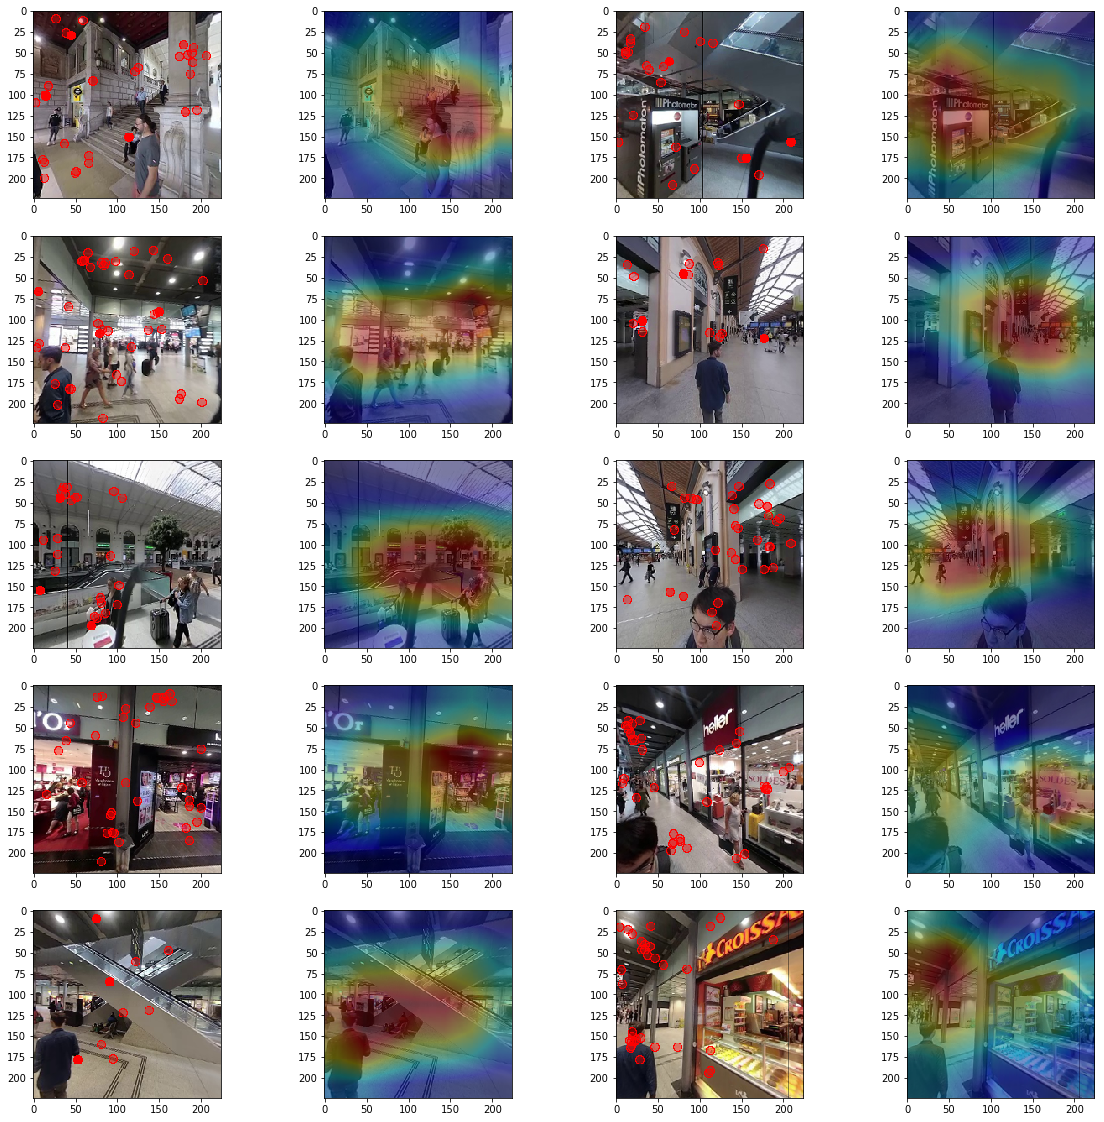

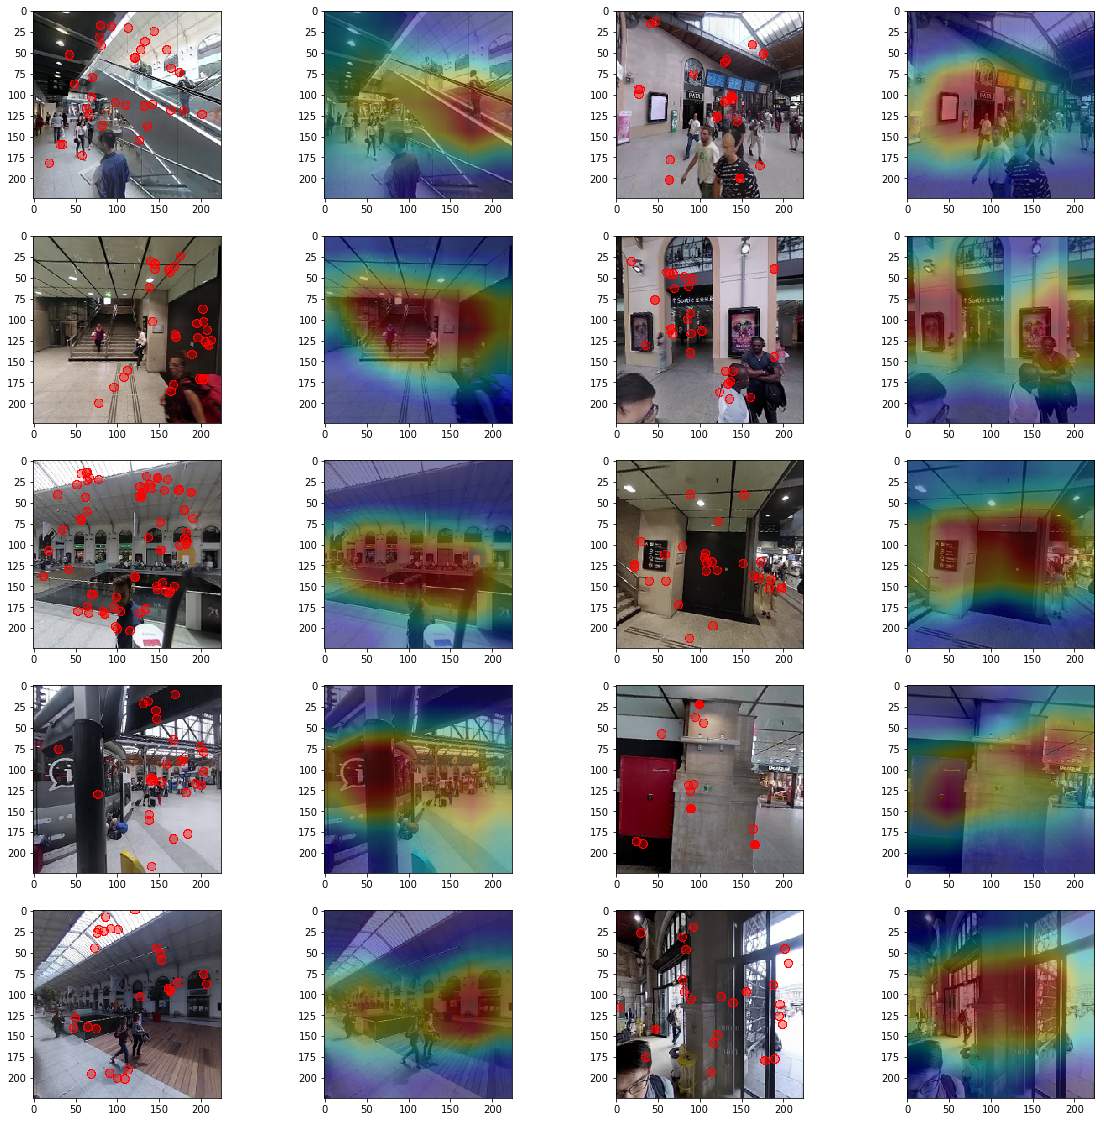

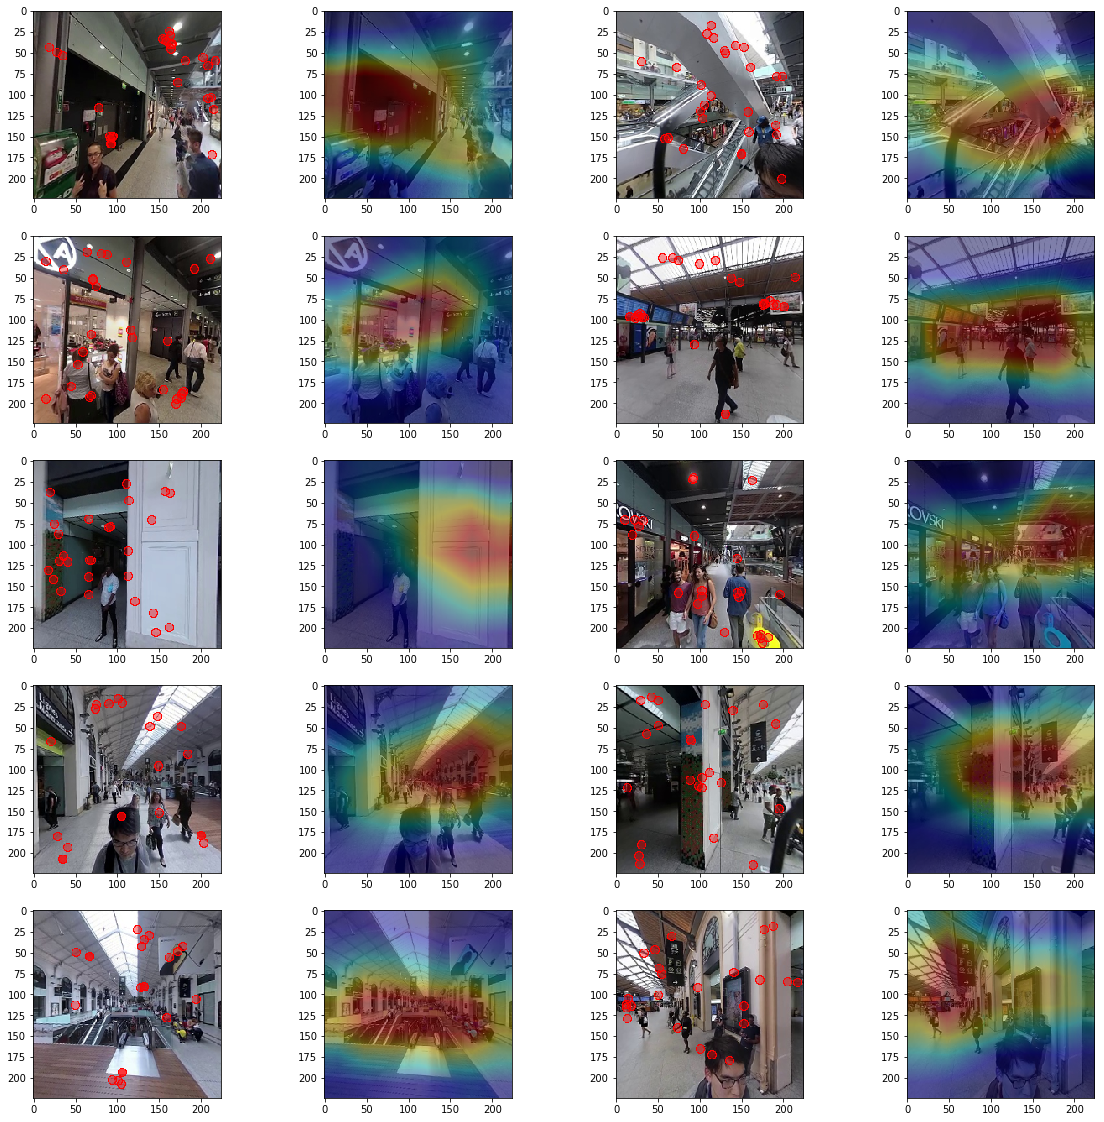

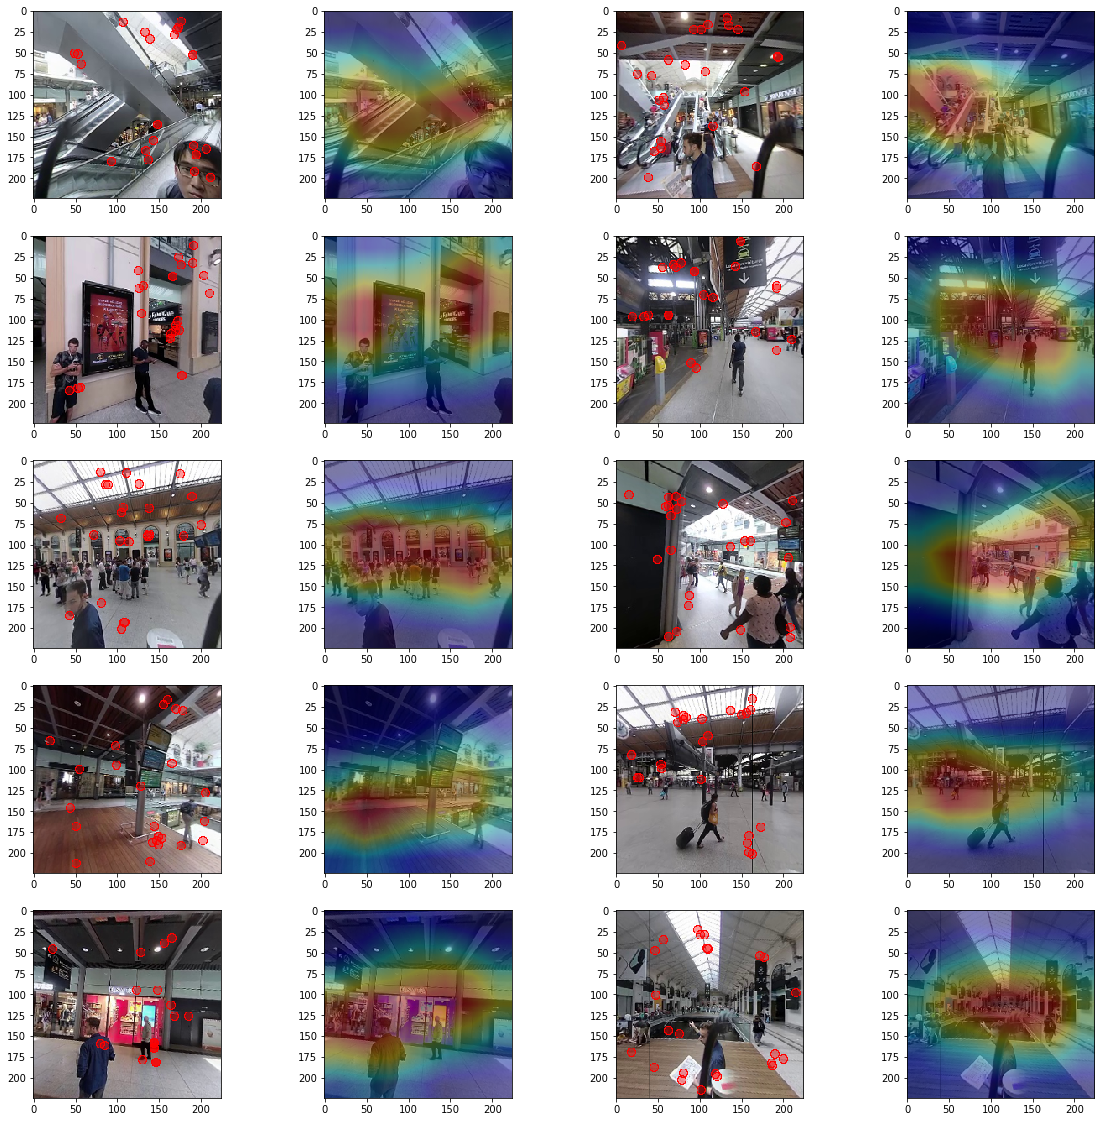

In [35]:
plt_row = 5
plt_column = 4
# image, heatmap = shuffle(image, heatmap)
print(len(image))
for a in range (len(image) / (plt_row * plt_column / 2)):
    fig=plt.figure(figsize=(20, 20))

    for i in range(plt_column * plt_row / 2):
        fig.add_subplot(plt_row, plt_column, i * 2 + 1)
        plt.imshow(image[a * plt_row * plt_column / 2 + i])
        
#         fig.add_subplot(plt_row, plt_column, i * 2 + 2)
#         heatmap_64, extent_64 = heatmap_plot(points[a + i][0], points[a + i][1], nb=16)
#         plt.imshow(heatmap_64, extent=extent_64, origin='lower', aspect='auto')
    
        fig.add_subplot(plt_row, plt_column, i * 2 + 2)
        plt.imshow(heatmap[a * plt_row * plt_column / 2 + i])
        
#     plt.tight_layout()
    plt.savefig('../presentation/survey_heatmap/%s.png' % a)    
    plt.show()
